In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install cython pycocotools

In [3]:
import os
import torch
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset


class COCODataset(Dataset):
    def __init__(self, root, train, transform=None):
        super().__init__()
        directory = "train" if train else "val"
        annotations = os.path.join(root, "annotations", f"{directory}_annotations.json")
        #coco_dataset 안에 있는 annotations 파일 안에서 json파일 가져오기

        self.coco = COCO(annotations) #COCO 함수에 전달.
        self.iamge_path = os.path.join(root, directory)
        self.transform = transform

        self.categories = self._get_categories()
        self.data = self._load_data()

    def _get_categories(self):
        categories = {0: "background"}
        for category in self.coco.cats.values(): #json 파일의 categories 속성 순차적으로 불러옴
            categories[category["id"]] = category["name"] #categorie는 딕셔너리 파일(id, name, supercategory)
        return categories

    def _load_data(self):
        data = []
        for _id in self.coco.imgs: #json 파일의 images id 속성 순차적으로 불러옴
            file_name = self.coco.loadImgs(_id)[0]["file_name"] #json파일의 image_id의 file_name 추출 리스트 형식 반환이라 첫번째 딕셔너리만 추출
            image_path = os.path.join(self.iamge_path, file_name) #file_name에 해당하는 이미지 path 설정
            image = Image.open(image_path).convert("RGB") #image를 RGB형태로 변형해서 불러오기

            boxes = []
            labels = []
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id)) #img_id를 가지는 annotation 정보 가져오기
            for ann in anns:
                x, y, w, h = ann["bbox"] #이미지 annotation 안에 있는 bbox좌표와 category_id 불러와 데이터 형성

                boxes.append([x, y, x + w, y + h])
                labels.append(ann["category_id"])

            target = {
            "image_id": torch.LongTensor([_id]),
                "boxes": torch.FloatTensor(boxes),
                "labels": torch.LongTensor(labels)
            } #데이터 형태 tensor로 변환 target 안에는 image_id 그 안에 객체들 정보 포함
            data.append([image, target]) #이미지 순석대로 인덱스 형성
        return data

    def __getitem__(self, index):
        image, target = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.data)

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader


def collator(batch):
    return tuple(zip(*batch))

transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

train_dataset = COCODataset("/content/drive/MyDrive/datasets/coco", train=True, transform=transform)
test_dataset = COCODataset("/content/drive/MyDrive/datasets/coco", train=False, transform=transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator
)

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [6]:
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN


backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features #백본 모델의 feature추출 층만 가져오기
backbone.out_channels = 512 #out_channels 할당

anchor_generator = rpn.AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
) #앵커의 갯수는 5*3= 15개
roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=(7, 7),
    sampling_ratio=2
) #roi_pooler로는 Multiscale roi align 사용 출력 크기는 7,7로 통일

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FasterRCNN(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.9MB/s]


In [7]:
from torch import optim


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [8]:
for epoch in range(5):
    cost = 0.0
    for idx, (images, targets) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #이미지와 타겟을 Device로 이동시키기

        loss_dict = model(images, targets) #Faster RCNN 모델은 딕셔너리 형태로 총 4개의 손실 출력
        losses = sum(loss for loss in loss_dict.values()) #합쳐서 역전파를 위한 값을 전달.

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        cost += losses

    lr_scheduler.step()
    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.68 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.35 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 5.98 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # C

Epoch :    1, Cost : 0.459


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.31 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.65 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 7.38 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # C

Epoch :    2, Cost : 0.308


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 7.20 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 5.69 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.67 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # C

Epoch :    3, Cost : 0.280


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 5.72 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.34 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 3.51 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # C

Epoch :    4, Cost : 0.269


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.83 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch :    5, Cost : 0.258


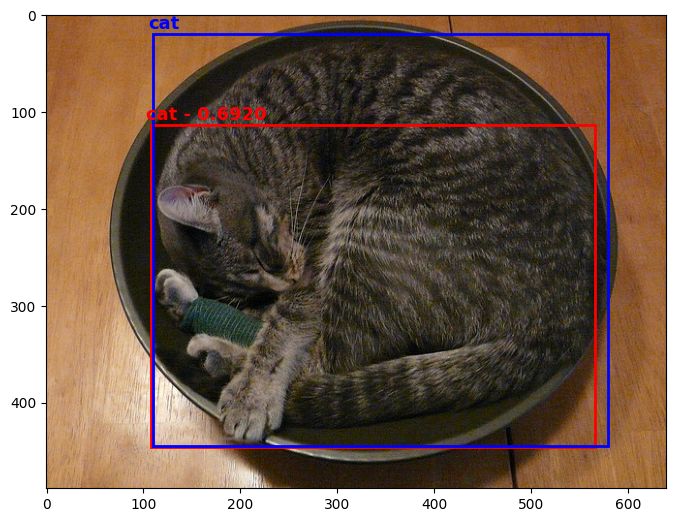

In [15]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image


def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )

threshold = 0.5
categories = test_dataset.categories
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()

        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0]))

        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()
        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")

        plt.show()
        break

In [10]:
import numpy as np
from pycocotools.cocoeval import COCOeval


with torch.no_grad():
    model.eval()
    coco_detections = []
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()

            for instance_id in range(len(boxes)):
                box = boxes[instance_id, :].tolist()
                prediction = np.array(
                    [
                        image_id,
                        box[0],
                        box[1],
                        box[2],
                        box[3],
                        float(scores[instance_id]),
                        int(labels[instance_id]),
                    ]
                )
                coco_detections.append(prediction)

    coco_detections = np.asarray(coco_detections)
    coco_gt = test_dataloader.dataset.coco
    coco_dt = coco_gt.loadRes(coco_detections)
    coco_evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

Loading and preparing results...
Converting ndarray to lists...
(1869, 7)
0/1869
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.424
 Average Recall     

In [13]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image


def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )

threshold = 0.5
categories = test_dataset.categories
with torch.no_grad():
    model.eval()
    images, targets = test_dataset[0]
    images = [image.to(device) for image in images]
    outputs = model(images)

    boxes = outputs[0]["boxes"].to("cpu").numpy()
    labels = outputs[0]["labels"].to("cpu").numpy()
    scores = outputs[0]["scores"].to("cpu").numpy()

    boxes = boxes[scores >= threshold].astype(np.int32)
    labels = labels[scores >= threshold]
    scores = scores[scores >= threshold]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(to_pil_image(images[0]))

    for box, label, score in zip(boxes, labels, scores):
        draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

    tboxes = targets[0]["boxes"].numpy()
    tlabels = targets[0]["labels"].numpy()
    for box, label in zip(tboxes, tlabels):
        draw_bbox(ax, box, f"{categories[label]}", "blue")

    plt.show()

ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([640, 529])